# Introduction
Before the 2020 olympics commenced, many in the host nation of Japan  feared the games would cause an explosion of COVID cases when they were already so high. The games serve as an isolated testing ground of the effectiveness of vaccines and social distancing measures on both the vaccinated and unvaccinated. I wish to take a retrospective on COVID and its impact on the 2020 Olympic games, looking the disease's effect on nations, sports, and individuals during the games. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("white")
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.stats import wilcoxon
from random import sample
from math import floor
from collections import defaultdict

In [2]:
#makes clean figures, by removing axes and labels in standalone histograms
def clean_fig(fig,title,y,x):
    #cleans up labeling
    fig.set(Title=title, ylabel=y,xlabel=x)#,xticklabels=[],xticks=[])
    #removes coloring 
    fig.set_facecolor('none')
    #removes uneeded lines
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=True, trim=True)
    return fig
def clean_replot(fig,title,y,x):
    #cleans up labeling
    fig.set(Title=title, ylabel=y,xlabel=x)
    #removes coloring 
    #fig.set_facecolor('white')
    #removes uneeded lines
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=True, trim=True)
    return fig
#uses basic probability to predict athletes whose vacc status is unknown, most generous possible interpretation
#since athletes r younger
def un_dealer(nations,vac_dict):
    unknown = defaultdict(int)
    vac,uvac=0,0
    #deal with athletes with unknown vaccine status
    for index, row in oly.iterrows():
        if row[4]!='UK':continue
        unknown[row[1]]+=1
    #calc unknowns likelyhood to be vacced 
    for i in range(len(nations)):
        #grab nation for athlete
        nat=nations[i]
        if nat not in unknown: continue
        #grab vacc rate for nation
        vrate=vac_dict[nat]
        #shift number of unknowns to vac and u-vac with this info
        vac,uvac=vac+abs(unknown[nat]*vrate), uvac+abs(unknown[nat]*(1-vrate))
    print("add "+str(vac)+" to vaccinated athletes and "+str(uvac)+' to unvaccinnated athletes')
    return vac,uvac
#makes clean figures, by removing axes and labels in standalone bar graph
def clean_fig_bar(fig,title,y,x,ticks):
    #cleans up labeling
    fig.set(Title=title, ylabel=y,xlabel=x,xticklabels=ticks,)
    #removes coloring 
    fig.set_facecolor('none')
    #removes uneeded lines
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=True, trim=True)
    return fig
#performs wilcoxons test on various population estimates of the covid-positive olympians
def perform_wilc(population,test_pop):
    sample_size= sum(test_pop)
    #matches sample_size (size of sample)
    subpopulation=sample(population,test_pop[0]+test_pop[1])
    test_pop=[0]*(test_pop[0])+[1]*(test_pop[1])
    w,p=wilcoxon(subpopulation,test_pop)
    print('The p-value of this population differential is: ',p)
    return p

# Data Collection
There is no true centralized source on athletes who contracted COVID during the games. There are some summary news articles who claim to be centralized sources, but they are all missing some athletes. So, I ended up looking at many sources for covid withdrawal, until I found no new athletes. Thus it is likely I may be missing a few cases. For numbers on the number of athletes competing in each sport and the number of athletes representing a nation, I used the tokyo 2020 olympics website(https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/athletes.htm). For information regarding case and vaccination rates I used (https://covidvax.live/) which tracks world-wide covid cases and vaccination in real-time.

# Data explanation
There's three dataframes that are manipulated in this notebook
* oly = Olympian data: describes all of the athletes who had to withdraw from the olympics due to a positive COVID test
    * Name: name of athlete
    * Country: country athlete is competing for 
    * Sport: sport olympian was competing in 
    * Cause: the cause of their positive COVID diagnosis
    * Vaccinated: was the athlete vaccinated, unvaccinated, or is their status unclear
* nation = Nation data: describes nations who lost athletes from a positive COVID withdrawal 
    * nation: name of country
    * #ath: number of athletes from nation entered in the games
    * vrates: the vaccination rate of the nation circa 7/23
* sport_info = sport data: describes sports who lost athletes from a positive covid withdrawal
    * Sport: name of sport
    * num: number of athletes competing in sport

In [3]:
#read in and clean up dataframes
sns.set(rc={'figure.figsize':(10,5)})
#df on nation info 
nation=pd.read_excel('nation_info.xlsx',header=0,encoding="encoding='utf-8")
#df on athlete info
oly=pd.read_excel('olympics.xlsx',header=0,encoding="encoding='utf-8")
#for future scaling by olympians at games, used later
oly['norm']=[1]*len(oly.index)
oly.columns = oly.columns.str.rstrip()
oly['Sport']=[f.capitalize() for f in oly['Sport']]
#df on sport info
sport_info=pd.read_excel('sport_info.xlsx')
sport_info['w_num']=[1/i for i in sport_info['num']]
sport_info['Sport']= [f.capitalize() for f in sport_info["Sport"]]

# COVID withdrawal by sport
First we will look at a wordcloud to see which sports were most affected by COVID raw-numbers wise.

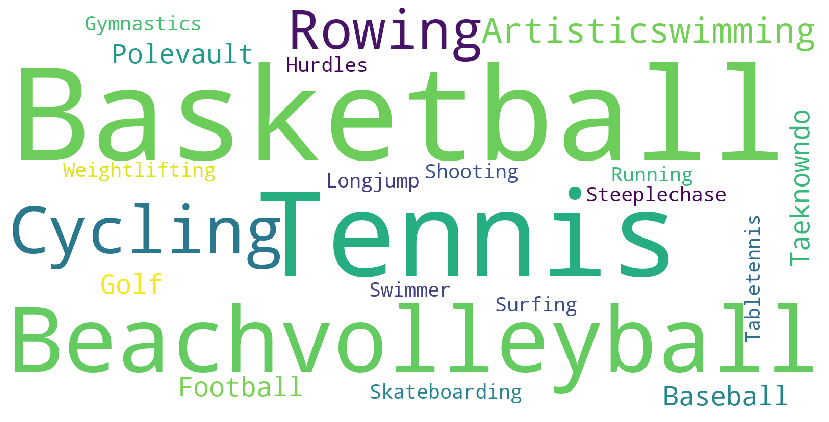

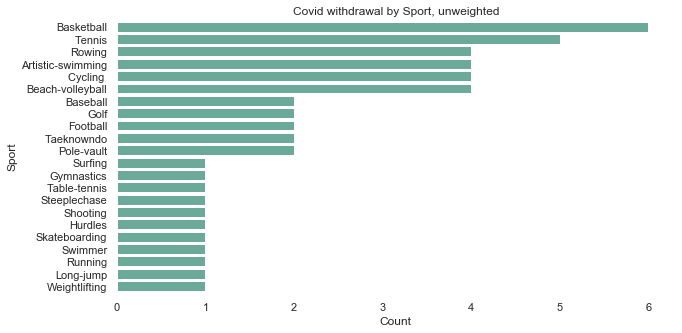

In [4]:
#form wordcloud for most affected sports
words=(' '.join(list(oly['Sport']))).replace('-','')
wordcloud = WordCloud(background_color='white',width=1600,height=800).generate(words)
plt.figure( figsize=(15,7.5) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#used for graph coloring 
teal=list((sns.cubehelix_palette(dark=0.1,light=0.9,hue=1,rot=-.4,n_colors=1*len(set(oly['Sport'])))))

#create barplot
hist=sns.countplot(data=oly,y='Sport',alpha=1,color=teal[8],order = oly['Sport'].value_counts().index)
clean_fig(hist,'Covid withdrawal by Sport, unweighted','Sport',"Count")
print()

Basketball, Cycling, and tennis appear to have taken the largest losses raw-numbers wise. 

# Normalizing losses by sport
Some sports have more athlete participants than others. This can be due to popularity, team vs. individual sports, or global influnce. Thus to measure the impact of COVID on each sport, we should weight the covid withdrawals by the number of athletes entered in the sport. For ease of computation, these sport numbers include male and female participants.

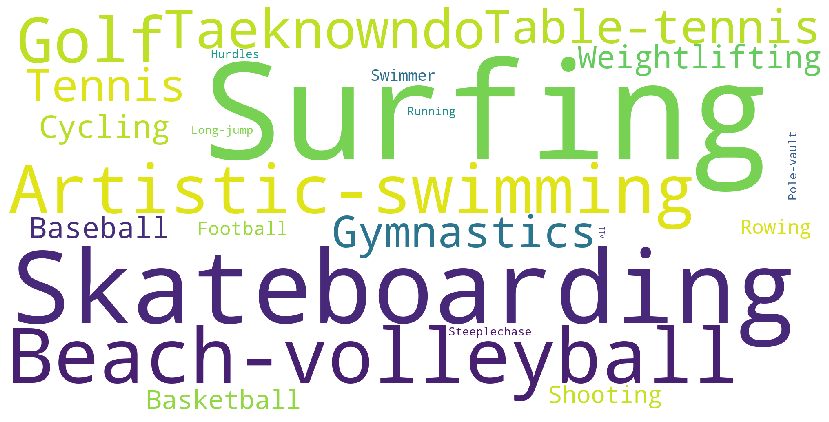

48


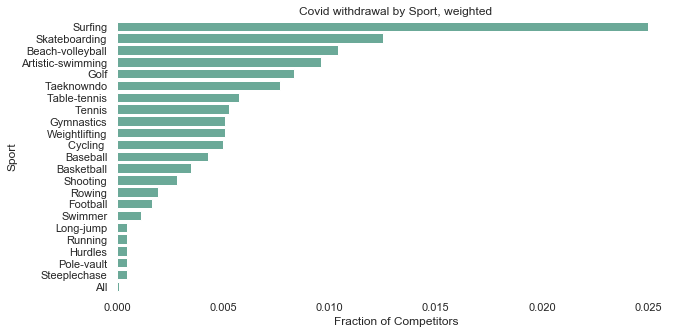

In [16]:
#contains weighted losses for sports 
w_sport_participants=dict(zip(sport_info['Sport'],sport_info['w_num']))
#form wordcloud for most affected sports (comparatively )
wordcloud = WordCloud( background_color='white',width=2000,height=1000)
wordcloud.generate_from_frequencies(frequencies=w_sport_participants)
plt.figure( figsize=(15,7.5) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#create and clean barplot
hist=sns.barplot(data=sport_info, y='Sport',x='w_num',alpha=1,color=teal[8])
clean_fig(hist,'Covid withdrawal by Sport, weighted','Sport',"Fraction of Competitors")
print(len(oly))

Looking at this data weighted paints a very different picture. All of the previous biggest losers (excluding beach volleyball) have a much lower loss rate when considering **how** many athletes were entered into the sport. Basketball lost the most athletes number-wise, but when considering the number of olympians competing in basketball, it lost a middling number of athletes
Most importantly, when considering all athletes, very few were infected with COVID.



# Covid Withdrawal by nation
We will now consider which nations were most affected by COVID withdrawals

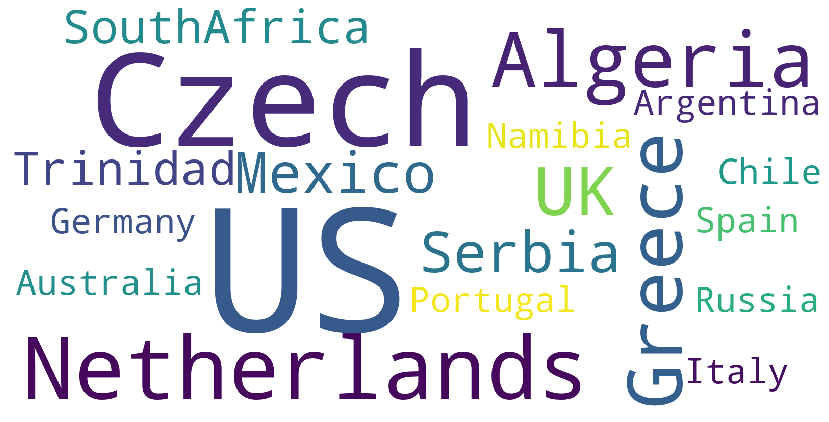

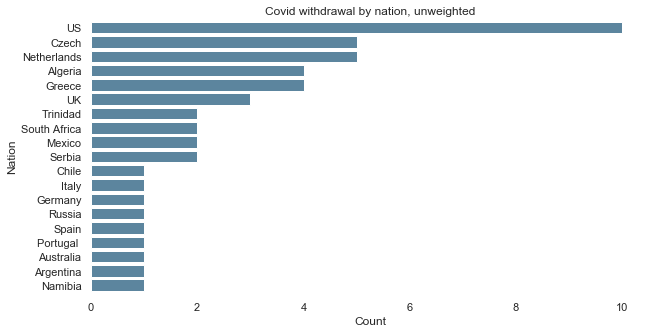

In [6]:
words=(' '.join(list(oly['Country']))).replace('South Africa','SouthAfrica')
wordcloud = WordCloud(background_color='white',width=1600,height=800).generate(words)
plt.figure( figsize=(15,7.5) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#color used for nation plots
blues=list((sns.cubehelix_palette(rot=-.25,hue=1,light=.75,n_colors=1*len(set(oly['Country'])))))
hist=sns.countplot(data=oly,y='Country',alpha=1,color=blues[8],order=oly['Country'].value_counts().index)
clean_fig(hist,'Covid withdrawal by nation, unweighted','Nation',"Count")
print()

The US lost the most athletes to COVID, but also had the largest number of entrants into the games. The Netherlands and the Czech Republic experienced similar losses. The Czech withdrawals come from one of the largest outbreaks during the games: a superspreader event on their private plane ride to Japan where their personal doctor was COVID positive. All Czech withdrawals are from this event.
# Normalizing losses by nations


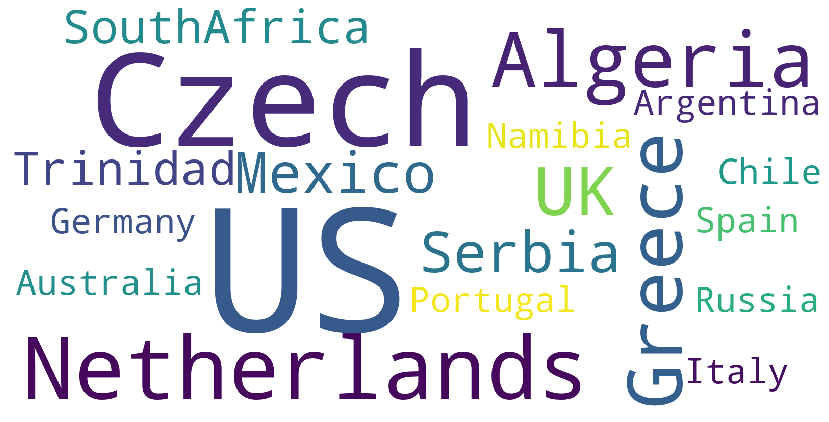

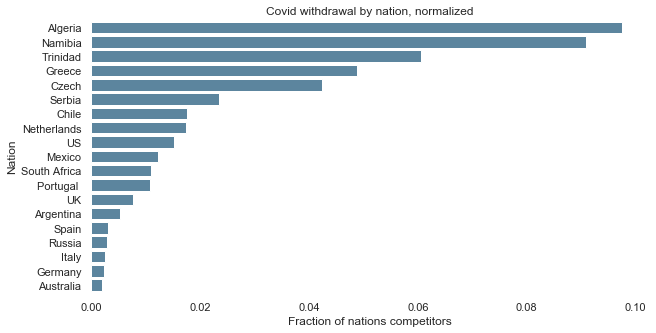

In [7]:
#raw numbers
athletes_by_nation=dict(zip(nation['nation'],nation['#ath']))
update=[]
#tranform raw numbers to athletes entered in games
cts=oly['Country'].value_counts().rename_axis('Country').reset_index(name='counts')
for row,value in cts.iterrows():
    update.append((1/(athletes_by_nation[value[0].strip(' ')]))*value[1])
cts['norm']=update
cts.sort_values('norm',inplace=True,ascending=False)

#wordcloud of nations worst losses comparatively 
wc = WordCloud(background_color='white',width=1600,height=800)
wc.generate_from_frequencies(dict(zip(cts['Country'],cts['norm'])))
plt.figure( figsize=(15,7.5) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#barplot of same
bar=sns.barplot(y=cts['Country'],x=cts['norm'],color=blues[8])
clean_fig(bar,'Covid withdrawal by nation, normalized','Nation',"Fraction of nations competitors")
print()

When considering COVID losses as a fraction of the nations olympic competitors, Algeria and Namibia experienced the heavest losses. While Algeria also had high withdrawal stats before this normalization, Namibia did not. In fact Namibia only lost one athlete to COVID, but since they had so few atheltes entered the impact was large. Even though the US lost the most athletes due to covid, when considering **how** many athletes US entered in the olympics, their losses had a lower impact
# Covid Withdrawal by nation Expectation vs. reality

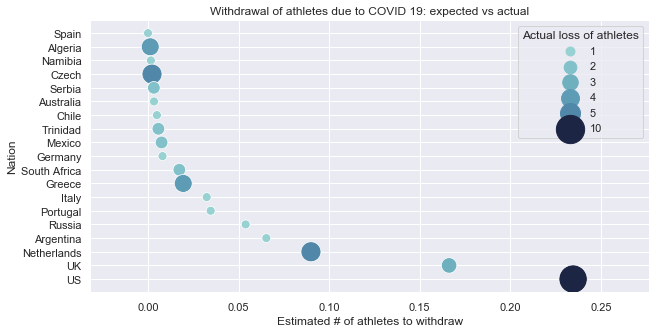

In [8]:
#find rough expectation of lost athletes. overestimation, since it assumes no immunity
wcases= lambda a,b,c  : (a/b)*c
nation['wc']=wcases(nation['cases'],nation['population'],nation['#ath'])
cts.sort_values(by='Country',inplace=True,ignore_index=True)
nation.sort_values(by='nation',inplace=True,ignore_index=True)
nation['actual_loss']=cts['counts']
nation.sort_values(by='wc',inplace=True,ignore_index=True)
g=sns.scatterplot(marker='o',legend="full",data=nation,size='actual_loss',x='wc',y='nation',hue='actual_loss',palette="ch:rot=-.25,hue=1,light=.75",sizes=(80, 800))
g.legend(title='Actual loss of athletes')
#this data is literally wrong
clean_replot(g,'Withdrawal of athletes due to COVID 19: expected vs actual','Nation','Estimated # of athletes to withdraw')
print()

The US had the most athletes withdraw, but they also had the most **estimated** athletes to withdraw. A similar trend is seen with the Netherlands. Spain, Algeria, Namibia, and Czechia had the lowest estimated olympian losses. Algeria and Spain performed the worst out of this low expectation. Though its important to note that **all** of these nations performed worse than expectation.
# COVID vaccination status, all olympians
The general vaccination rate of Olympians is known: 80% of Olympians are vaccinated and 20% are unvaccinated. This far outstrips the global rate, highlighting the importance of the games to the organizers and athletes themselves. The olympics are a once in a life time opportunity for the majority of participating athletes. The barplot below illustrates this known vaccination rate among **all atheles**. This serves as a good comparison to the COVID positive athletes' estimated vaccination rate. 

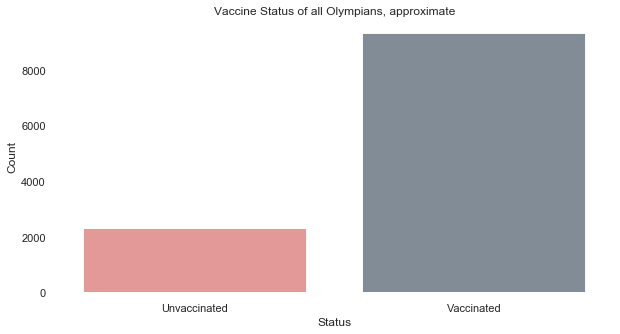

In [9]:
#esimation of vaccinated athletes based on published summary data 
v_status_all=[0]*(int(11656*.2))+([1]*(int(11656*.8)))
count=sns.countplot(x=v_status_all,alpha=.9,palette=['lightcoral','slategray'])
clean_fig_bar(count,"Vaccine Status of all Olympians, approximate","Count","Status",['Unvaccinated','Vaccinated'])
print()

# COVID Vaccination Status, all withdrawn olympians
## Dealing with unknowns
* While the total vaccination rate is known, individual athletes do not have to publicize their vaccine status or be vaccinated to compete in the olympics. So many of the COVID positive olympic drop-outs have unknown vaccine statuses. Thus assumptions about the data need to be made. I divided Olympians into 4 categories: Vaccinated, Unvaccinated, Unknown, and Unlikely.
* **Vaccinated**: fully vaccinated athletes
* **Unvaccinated**: athletes with confirmed no vaccination
* **Unknown**: athletes with unknown vaccine status
* **Unlikely**: athletes with unknown vaccine status, but a very low likelyhood of vaccination. This is used in the case of extremely young athletes (likely inelgible for vaccination), countries with extremely low vaccination rates, or partially vaccinated athletes (where their level of protection is unknown).

Due to the large quantity of unknowns/unlikelys, assumptions about the data need to be made to perform further analysis. There are many ways to do this but I will attempt three general methods

# 1. The generous method

1. Convert all unlikelys to unknowns. 
2. Convert unkowns to vaccinated/unvaccinated, using the vaccination status of the country (as of the first day of the olympics 7/23/21 or closest known date) with the following formula. 



    additional vacccinated olympians= (vrate/100)x(number of unknown athletes)

    additional unavaccinated olympians= number of unknown athletes-additional vacccinated olympians

# 2. Middle of the road
1. Convert all unlikelys to unvaccinated.
2. Convert unkowns to vaccinated/unvaccinated, using the vaccination status of the country (as of the first day of the olympics 7/23/21) with the following formula: 
    
    
    add (vrate/100)*(number of unknown athletes) to vaccinated olympians
    
    add ((1-vrate)/100)*(number of unknown athletes) to unvaccinated olympians


# 3. Strictest (and most probable) method
The most likely reason that an athlete has not exposed their vaccination status after being forced to withdraw from the olympics, possibly the highest stakes sporting event of their career, is that they were embarassed to be unvaccinated.

1. Convert all unlikelys and unknowns to unvaccinated.

In [10]:
#make sure works for method 1 and 2
nation['adj_vrates']= [i/100 for i in nation['vrates']]
vac,uvac=un_dealer(nation['nation'],dict(zip(nation['nation'],nation['adj_vrates'])))

add 12.7239 to vaccinated athletes and 11.2761 to unvaccinnated athletes


# Results of Method 1

The p-value of this population differential is:  0.038947455742025384


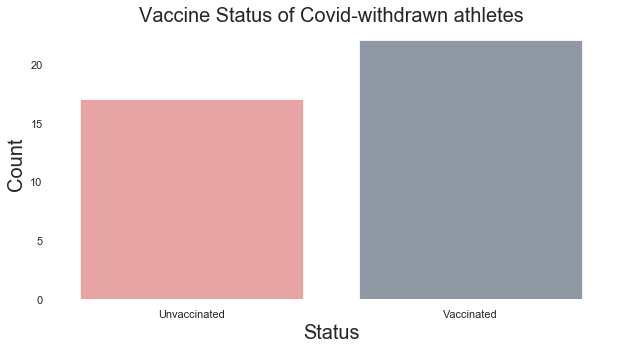

In [11]:
#consider NL UK (generous)
#get rates of 3 (in this case) possible options
unique, counts = np.unique(oly['Vaccinnated'].replace('NL','UK').replace('Y* 14 ','Y'), return_counts=True)
#update unvaccinated and vaccinated numbers with these estimations
counts[0]+=uvac
counts[2]+=vac
counts,unique= [counts[0],counts[2]], [unique[0],unique[2]]
#make figure more readable
sns.set(rc={'figure.figsize':(10,5)})
fig=sns.barplot(y=counts,x=unique,alpha=.8,palette=['lightcoral','slategray'])
clean_fig_bar(fig,"Vaccine Status of Covid-withdrawn athletes","Count","Status",['Unvaccinated','Vaccinated'])
for item in ([fig.title, fig.xaxis.label, fig.yaxis.label]):
        item.set_fontsize(20)

#will be randomly sampled by perform_wilc
x=[0]*(int(11656*.2))+([1]*(int(11656*.8)))
ans=perform_wilc(x,counts)

* This extremely forgiving method of estimating vaccination status still overrepresents unvaccinated individuals: 20% of the general population is unvaccinated, but 50% of the covid positive olympians are unvaccinated. This differential is almost certainly caused by the effectiveness of the vaccine in the 80% of the athletes who were vaccinated. The p-value (wilcoxon method) of this differential by chance is significant by conventional measures.

# Results of method 2

The p-value of this population differential is:  0.0028375448887923097


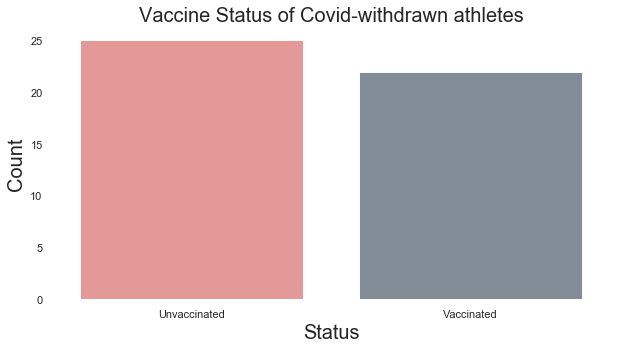

In [12]:
#consider NL No, otherwise same logic as method 1
unique, counts = np.unique(oly['Vaccinnated'].replace('NL','N').replace('Y* 14 ','Y'), return_counts=True)
counts[0]+=uvac
counts[2]+=vac
counts,unique= [counts[0],counts[2]], [unique[0],unique[2]]

fig=sns.barplot(y=counts,x=unique,alpha=.9,palette=['lightcoral','slategray'])
clean_fig_bar(fig,"Vaccine Status of Covid-withdrawn athletes","Count","Status",['Unvaccinated','Vaccinated'])
for item in ([fig.title, fig.xaxis.label, fig.yaxis.label]):
        item.set_fontsize(20)
ans=perform_wilc(x,counts)

Here the data looks more realistic than method 1 due to the relative rarity of breakthrough cases post-vaccination. The unvaccinated slightly outweigh the vaccinated in this estimation, the likelyhood of this happening is very low, as evidenced by the low p-value. 
# Results of method 3

The p-value of this population differential is:  6.79884997479191e-08


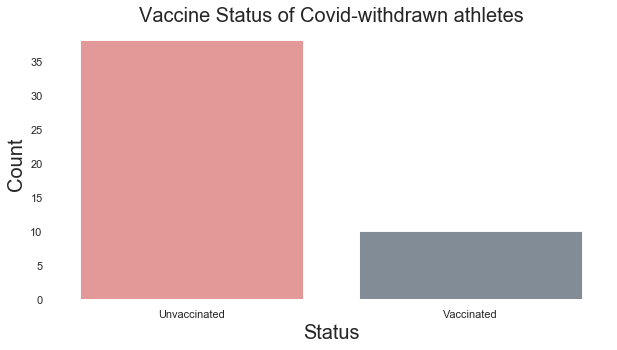

In [13]:
#consider NL No, uk no 
unique, counts = np.unique(oly['Vaccinnated'].replace('UK','N').replace('NL','N').replace('Y* 14 ','Y'), return_counts=True)
fig=sns.barplot(y=counts,x=unique,alpha=.9,palette=['lightcoral','slategray'])
clean_fig_bar(fig,"Vaccine Status of Covid-withdrawn athletes","Count","Status",['Unvaccinated','Vaccinated'])
for item in ([fig.title, fig.xaxis.label, fig.yaxis.label]):
        item.set_fontsize(20)
ans=perform_wilc(x,counts)

This graph better reflects the effectiveness of vaccination. We know that 80% of olympians were vaccinated, but those who caught covid do not match this ratio. The ratio is almost perfectly inverted, with 22% of the covid positive olympians being vaccinated and 78% unvaccinated. There are still breakthrough cases, but these are heavily outnumbered by the unvaccinated cases. The chance of this population inversion happening by chance is approximately 1 in 14.7 million.

# Summary 
## Sports
### *Worst Losses Numbers Wise*
1. Basketball
2. Tennis 
3. Rowing

### *Worst Weighted Losses* 
1. Surfing
2. Skateboarding
3. Beach volleyball

## Nations
### *Worst Losses Numbers Wise*
1. United States
2. Czechia
3. Netherlands

### *Worst Weighted Losses* 
1. Algeria 
2. Namibia
3. Trinidad and Tobago

### Top nations that lost more athletes than expected 
1. Algeria 
2. Namibia
3. Greece

## Vaccinations
*No matter how generously you calculate the vaccination status of the withdrawn olympians the population differential between them and the general olympian population is significant.*


## Closing Thoughts 
The most important statistic to keep in mind is the the fraction of competitors that had to withdraw: 48 out of 11,656. This equates to approxiamtely 1 242 athletes being forced to withdraw from the game. The olympics was not a super-spreader event as feared by denouncers. Overall the agressive precautions taken by the Tokyo 2020 olympic organizers were effective